## Cox Regression Experiments

### Load and Preprocess the Data

In [1]:
# import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as lflns
sns.set_style('whitegrid')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index

In [2]:
# run notebook containing function that evaluates
# predictions using the stratified concordance index
%run -i ../examples/concordance_index.ipynb

In [3]:
# Load training data
hct_df = pd.read_csv("../data/train_set.csv")

# Replace text value that corresponding so missing data with NaN
hct_df = hct_df.replace(to_replace=["Missing Disease Status", "Missing disease status"], value=np.nan)

# drop year column, which isn't appropriate for prediction
hct_df = hct_df.drop(columns=['year_hct'])

In [4]:
# Use one-hot encoding to encode categorical columns.
# The min_frequency option will bin very rare values
# of each categorical variable into a new
# 'infrequent' category.
# The minimum frequency of 0.001 corresponds to a 
# minimum of roughly 20 training samples.

cat_cols = list(hct_df.select_dtypes(include='O').columns)

encoder = ColumnTransformer(
    [
        ('one_hot', 
         OneHotEncoder(drop='first', 
                       min_frequency=0.001, 
                       handle_unknown='ignore',
                       ), 
        cat_cols
        ),
    ],
    sparse_threshold=0,
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

# Drop the ID column, which should not be used
# in prediction.
# We keep it in hct_df above, because it may 
# be needed for the custom score function.
df_enc = pd.DataFrame(encoder.fit_transform(hct_df), 
                      columns=encoder.get_feature_names_out()).drop("ID", axis=1)

### Fit a Cox Models with All Features

In [5]:
# Convenience function to create a pipeline
# the scales a passed-in list of numeric features,
# then uses a KNN-imputer to impute missing data.

def create_pipeline(to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score']):
    pipeline = Pipeline(
        [
            (
                "scale",
                ColumnTransformer(
                    [
                        ('scale', StandardScaler(), to_scale)
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )
            ),
            (
                "impute",
                KNNImputer()
            ),
        ]
    )

    return pipeline

In [6]:
def get_result_by_race(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'

    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    score_dict = {}
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        score_dict[race] = c_index_race
    return score_dict

In [7]:
# Perform five-fold cross validation using 
# an out-of-the-box Cox model on the encoded features.

feat_names = df_enc.columns[:-2]
target_names = ['efs', 'efs_time']

n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True)
c_indexes = np.zeros(n_splits)
scores = np.zeros(n_splits)
results_dicts = []

from lifelines import CoxPHFitter

for num, (train_idx, test_idx) in enumerate(kfold.split(df_enc)):
    print("Now starting fold {}".format(num))
    
    train = df_enc.iloc[train_idx]
    test = df_enc.iloc[test_idx]
    
    # Fit a pipeline to the training set for this split,
    # so that scaling and imputation are performed based
    # on the training data for this split only.
    pipeline = create_pipeline()

    X_train_proc = pd.DataFrame(pipeline.fit_transform(train[feat_names]), 
                                columns=pipeline.get_feature_names_out()).set_index(train_idx)
    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    X_test_proc = pd.DataFrame(pipeline.transform(test[feat_names]),
                              columns=pipeline.get_feature_names_out()).set_index(test_idx)
    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs')
    
    # Partial hazards from the Cox Proportional Hazard
    # model can be used as a risk score for an individaul
    preds = cph.predict_partial_hazard(test_proc)

    # Use custome scoring functions to evaluate model predictions
    solution = hct_df.iloc[test_idx]
    prediction = pd.DataFrame({"ID":hct_df.iloc[test_idx]["ID"], "prediction":preds})
    scores[num] = score(solution.copy(deep=True), prediction.copy(deep=True), "ID")
    c_indexes[num] = concordance_index(y_test_proc['efs_time'], -preds, y_test_proc['efs'])
    results_dicts.append(get_result_by_race(solution.copy(deep=True), prediction.copy(deep=True), "ID"))

Now starting fold 0
Now starting fold 1
Now starting fold 2
Now starting fold 3
Now starting fold 4


In [8]:
# Print ordinary c-index for each run
print(c_indexes)

# Print stratified concordance index for each run
print(scores)

[0.66790953 0.66984973 0.66275937 0.66782081 0.68068788]
[0.63600724 0.65895676 0.65220617 0.65261323 0.6665453 ]


In [9]:
# Find the average score for all splits
# in our five-fold cross-validations
np.mean(scores)

np.float64(0.6532657424548434)

In [10]:
print(np.mean(c_indexes))

0.6698054656971827


In [13]:
results_by_race = pd.DataFrame(results_dicts)
results_by_race.describe()

,American Indian or Alaska Native,Asian,Black or African-American,More than one race,Native Hawaiian or other Pacific Islander,White
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.669923,0.683731,0.661798,0.676859,0.662244,0.650493
std,0.015104,0.019987,0.011970,0.006818,0.009192,0.018952
min,0.657303,0.661538,0.641852,0.667164,0.650683,0.623277
25%,0.658481,0.670226,0.661578,0.673703,0.656111,0.640465
50%,0.667153,0.683664,0.663548,0.678424,0.662922,0.656837
75%,0.672057,0.689710,0.669867,0.679684,0.667478,0.659704
max,0.694624,0.713518,0.672143,0.685320,0.674026,0.672181


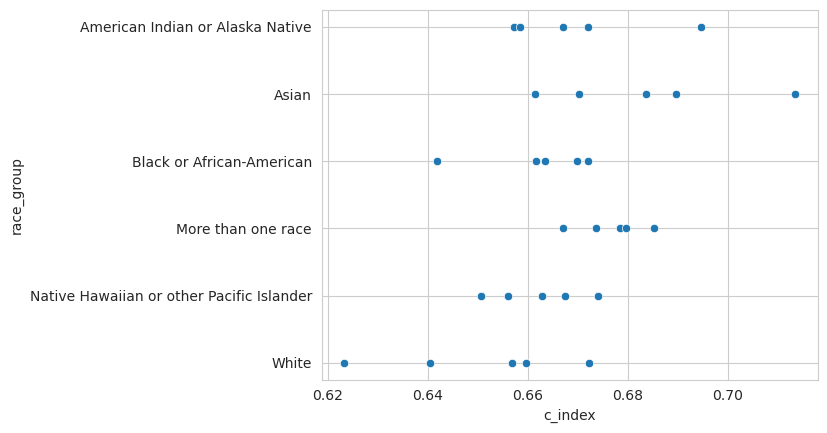

In [15]:
# Scatterplot of accuracy for each race group
# across 5-fold cross validation
results_by_race = pd.DataFrame(results_dicts)
to_plot = results_by_race.melt()
to_plot = to_plot.rename(columns={"variable":"race_group", "value":"c_index"})
sns.scatterplot(to_plot, y='race_group', x='c_index')
plt.show()

In [16]:
# Now try fitting the model on the entire training set.
pipeline = create_pipeline()

X_train_proc = pd.DataFrame(pipeline.fit_transform(df_enc[feat_names]), columns=pipeline.get_feature_names_out())
y_train_proc = df_enc[target_names]
train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

cph = CoxPHFitter()

cph.fit(train_proc, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [17]:
# Examine model metrics and coefficients
# for the cox model fit on the entire 
# training set.
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -118077.72
         time fit was run = 2025-04-07 02:06:21 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
donor_age                                                    0.04      1.04      0.01            0.02            0.06                1.02                1.06
age_at_hct                                                   0.03      1.03      0.01            0.01            0.06                1.01                1.06
karnofsky_score                                             -0.06      0.94      0.01           -0.08           -0.04                0.92                0.96
dri_score_High - TED AML case <missing cytogenetics         -0.36      0.70      0.05           -0.44           -0.27                0.64                0.77
dri_score_Intermediate                                      -0.44      0.64      0.03           -0.49           -0.39                0.61                0.68
dri_score_Intermediate - TED AML case <missing cytogenetics -0.34      0.71      0.07           -0.48           -0.20                0.62                0.82
dri_score_Low                                               -0.34      0.71      0.04           -0.42           -0.26                0.66                0.77
dri_score_N/A - disease not classifiable                    -0.49      0.62      0.11           -0.71           -0.26                0.49                0.77
dri_score_N/A - non-malignant indication                    -0.38      0.69      0.04           -0.46           -0.29                0.63                0.75
dri_score_N/A - pediatric                                   -0.38      0.69      0.03           -0.44           -0.31                0.64                0.74
dri_score_TBD cytogenetics                                  -0.28      0.75      0.05           -0.37           -0.19                0.69                0.83
dri_score_Very high                                         -0.23      0.79      0.13           -0.49            0.02                0.61                1.03
dri_score_nan                                               -0.62      0.54      0.13           -0.89           -0.36                0.41                0.70
psych_disturb_Not done                                       0.01      1.01      0.13           -0.25            0.26                0.78                1.30
psych_disturb_Yes                                            0.03      1.03      0.03           -0.02            0.09                0.98                1.09
psych_disturb_nan                                            0.09      1.10      0.06           -0.02            0.20                0.98                1.22
cyto_score_Intermediate                                      0.14      1.15      0.04            0.07            0.21                1.07                1.23
cyto_score_Normal                                            0.24      1.27      0.07            0.11            0.36                1.12                1.44
cyto_score_Not tested                                        0.04      1.04      0.20           -0.36            0.44                0.70                1.55
cyto_score_Other                                             0.25      1.28      0.07            0.10            0.39                1.11                1.48
cyto_score_Poor                                              0.22      1.25      0.03            0.15            0.29                1.16                1

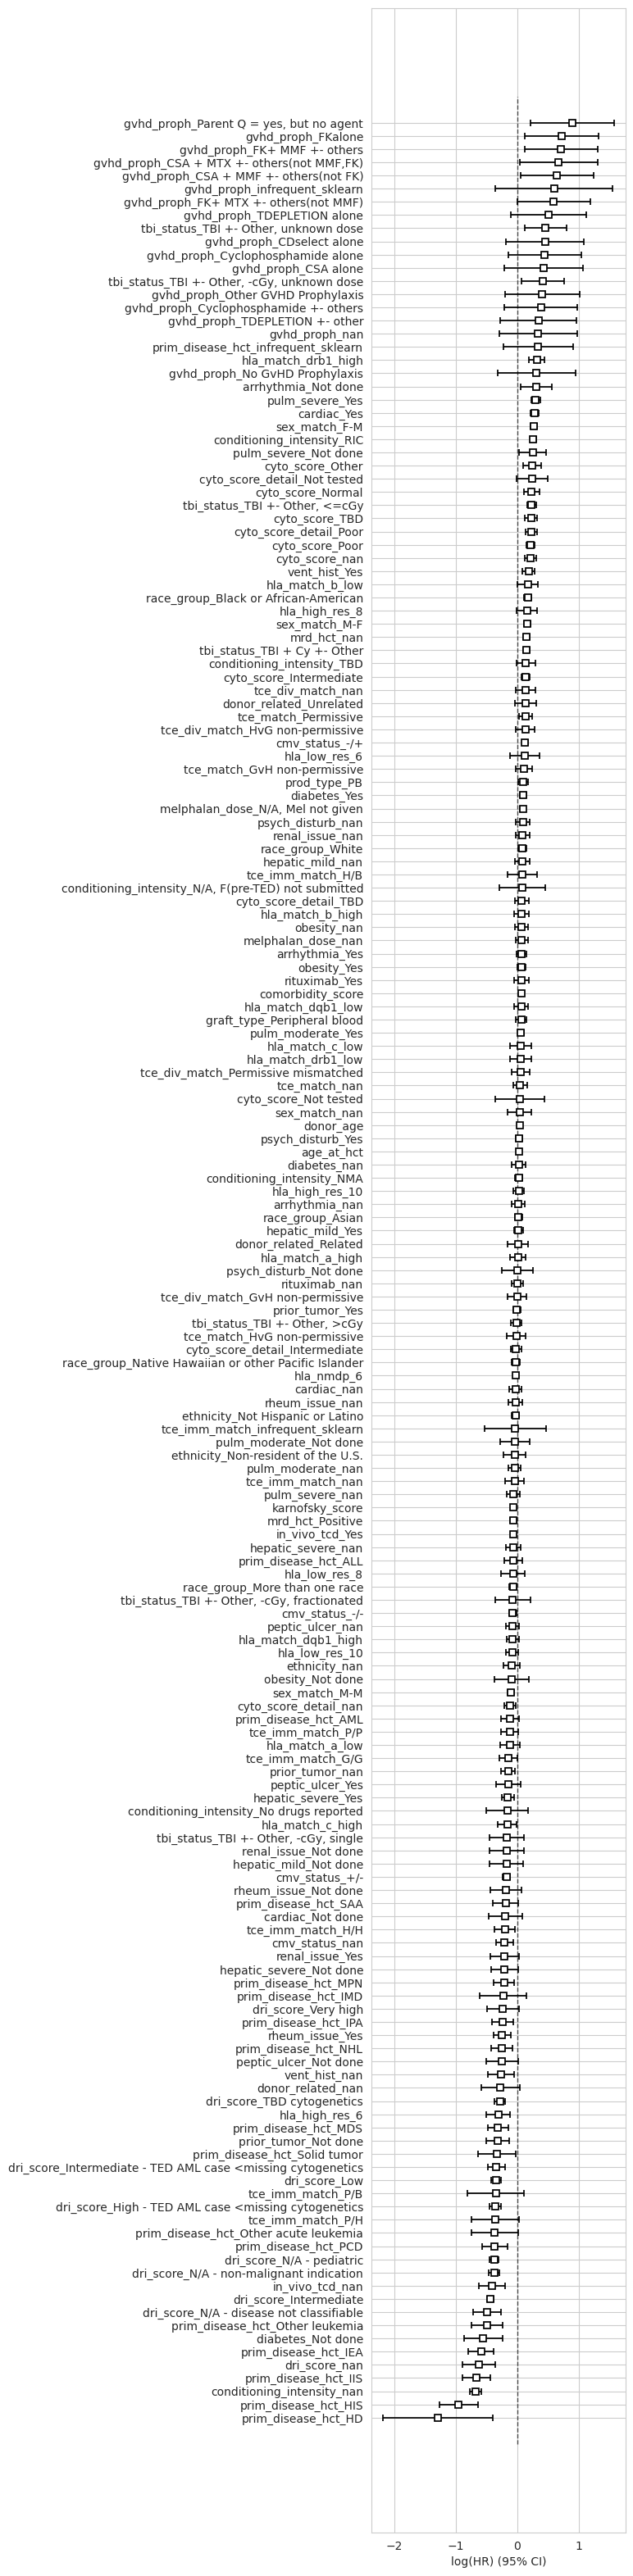

In [18]:
# Plot model coefficients from largest to smallest, with error bars.
# Notice that this model appears quite "noisy".
# Confidence intervals for many coefficients are quite wide,
# and may include zero.
# There are also many coefficients that are 
# close to zero, indicating that feature
# has very little impact.
plt.figure(figsize=(4, 40))
cph.plot()
plt.show()

### Drop Features Whose Coefficients Were Not Significant

In [19]:
# Create a dataframe of coefficients from the
# "out of the box" model.
# Add a column 'zero not in conf int' which records
# whether the confidence interval for the interval contains 0.
# If the confidence interval contains zero, that means
# we cannot say with 95% confidence that the feature
# has a non-zero impact on survival.
coefficient_info = pd.concat([cph.params_, cph.confidence_intervals_], axis=1).reset_index()
coefficient_info['abs_coef'] = abs(coefficient_info['coef'])
coefficient_info['zero not in conf int'] = coefficient_info['95% lower-bound'] * coefficient_info['95% upper-bound'] > 0

In [20]:
significant_coefs = coefficient_info.loc[coefficient_info['zero not in conf int']]
print("There are {} statistically significant coefficients".format(significant_coefs.shape[0]))

There are 78 statistically significant coefficients


In [21]:
# Repeat the 5-fold cross-validation with an 
# 'out of the box' Cox model, but this time
# drop all features whose coefficients were not 
# statistically signficant during the first experiment.
# Note that in general, this is not a best practice
# for feature selection: the goal here is 
# simply a rough first pass to see if we get
# comparable performance with a much
# smaller set of features.

key_columns = significant_coefs.covariate.to_list() + ['efs', 'efs_time']
scale_key = [col for col in ['donor_age', 'age_at_hct', 'karnofsky_score'] if col in key_columns]

df_key = df_enc[key_columns]
scale_key = [col for col in ['donor_age', 'age_at_hct', 'karnofsky_score'] if col in key_columns]
feat_names_key = key_columns[:-2]
c_indexes = np.zeros(n_splits)
scores = np.zeros(n_splits)
results_dicts = []

for num, (train_idx, test_idx) in enumerate(kfold.split(df_key)):
    
    train = df_key.iloc[train_idx]
    test = df_key.iloc[test_idx]
    
    pipeline = create_pipeline(scale_key)


    X_train_proc = pd.DataFrame(pipeline.fit_transform(train[feat_names_key]), 
                                columns=pipeline.get_feature_names_out()).set_index(train_idx)

    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    X_test_proc = pd.DataFrame(pipeline.transform(test[feat_names_key]), 
                               columns=pipeline.get_feature_names_out()).set_index(test_idx)
    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs')

    preds = cph.predict_partial_hazard(test_proc)

    solution = hct_df.iloc[test_idx]
    prediction = pd.DataFrame({"ID":hct_df.iloc[test_idx]["ID"], "prediction":preds})
    scores[num] = score(solution.copy(deep=True), prediction.copy(deep=True), "ID")
    c_indexes[num] = concordance_index(y_test_proc['efs_time'], -preds, y_test_proc['efs'])
    results_dicts.append(get_result_by_race(solution.copy(deep=True), prediction.copy(deep=True), "ID"))

print(scores)

[0.65094136 0.65062231 0.64818881 0.65024334 0.64837535]


In [27]:
print(c_indexes)

[0.67113763 0.66998142 0.66367241 0.67070044 0.66503714]


In [28]:
print(np.mean(c_indexes))

0.6681058063179243


In [22]:
# Average the cross-validated scores. 
# It seems that dropping non-signficiant 
# predictors had a negligable impact on performance.
np.mean(scores)

np.float64(0.6496742325581715)

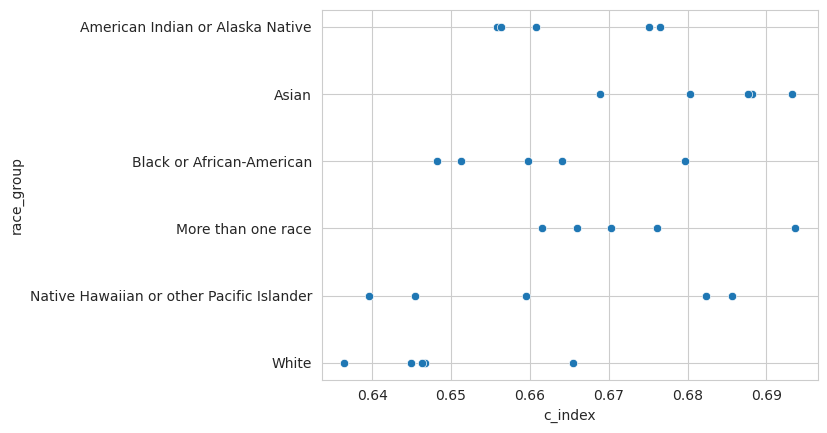

In [23]:
# Scatterplot of accuracy for each race group
# across 5-fold cross validation
results_by_race = pd.DataFrame(results_dicts)
to_plot = results_by_race.melt()
to_plot = to_plot.rename(columns={"variable":"race_group", "value":"c_index"})
sns.scatterplot(to_plot, y='race_group', x='c_index')
plt.show()

In [24]:
# Refit the Cox model on all rows of the training set,
# but using only features whose coeffients were statistically
# significant in the first attempt.
pipeline = create_pipeline(scale_key)

X_train_key = pd.DataFrame(pipeline.fit_transform(df_key[feat_names_key]), columns=pipeline.get_feature_names_out())
y_train_key = df_key[target_names]
train_key = pd.concat([X_train_proc, y_train_proc], axis=1)

cph2 = CoxPHFitter()
cph2.fit(train_key, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 18432 total observations, 8422 right-censored observations>

In [25]:
# Examine the metric and coefficients for the model
# with the restricted feature set.
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 18432 total observations, 8422 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 18432
number of events observed = 10010
   partial log-likelihood = -92919.94
         time fit was run = 2025-04-07 02:09:05 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
donor_age                                                    0.01      1.01      0.01           -0.01            0.03                0.99                1.03
age_at_hct                                                   0.03      1.03      0.01            0.00            0.06                1.00                1.06
karnofsky_score                                             -0.06      0.94      0.01           -0.08           -0.04                0.92                0.96
dri_score_High - TED AML case <missing cytogenetics         -0.39      0.68      0.05           -0.49           -0.29                0.62                0.75
dri_score_Intermediate                                      -0.45      0.63      0.03           -0.51           -0.40                0.60                0.67
dri_score_Intermediate - TED AML case <missing cytogenetics -0.30      0.74      0.08           -0.46           -0.14                0.63                0.87
dri_score_Low                                               -0.35      0.70      0.04           -0.44           -0.27                0.65                0.77
dri_score_N/A - disease not classifiable                    -0.41      0.67      0.12           -0.65           -0.17                0.52                0.85
dri_score_N/A - non-malignant indication                    -0.40      0.67      0.05           -0.50           -0.31                0.61                0.73
dri_score_N/A - pediatric                                   -0.37      0.69      0.04           -0.45           -0.30                0.64                0.74
dri_score_TBD cytogenetics                                  -0.31      0.73      0.05           -0.41           -0.21                0.66                0.81
dri_score_nan                                               -0.71      0.49      0.15           -1.00           -0.42                0.37                0.66
cyto_score_Intermediate                                      0.15      1.16      0.04            0.07            0.22                1.07                1.25
cyto_score_Normal                                            0.29      1.34      0.07            0.15            0.43                1.16                1.54
cyto_score_Other                                             0.28      1.32      0.08            0.12            0.44                1.13                1.55
cyto_score_Poor                                              0.25      1.28      0.04            0.17            0.32                1.19                1.38
cyto_score_TBD                                               0.28      1.33      0.06            0.17            0.39                1.19                1.48
cyto_score_nan                                               0.21      1.24      0.05            0.11            0.31                1.12                1.36
diabetes_Not done                                           -0.66      0.52      0.19           -1.03           -0.30                0.36                0.74
diabetes_Yes                                                 0.07      1.07      0.03            0.02            0.13                1.02                1.13
tbi_status_TBI + Cy +- Other                                 0.17      1.18      0.03            0.11            0.22                1.12                1.2

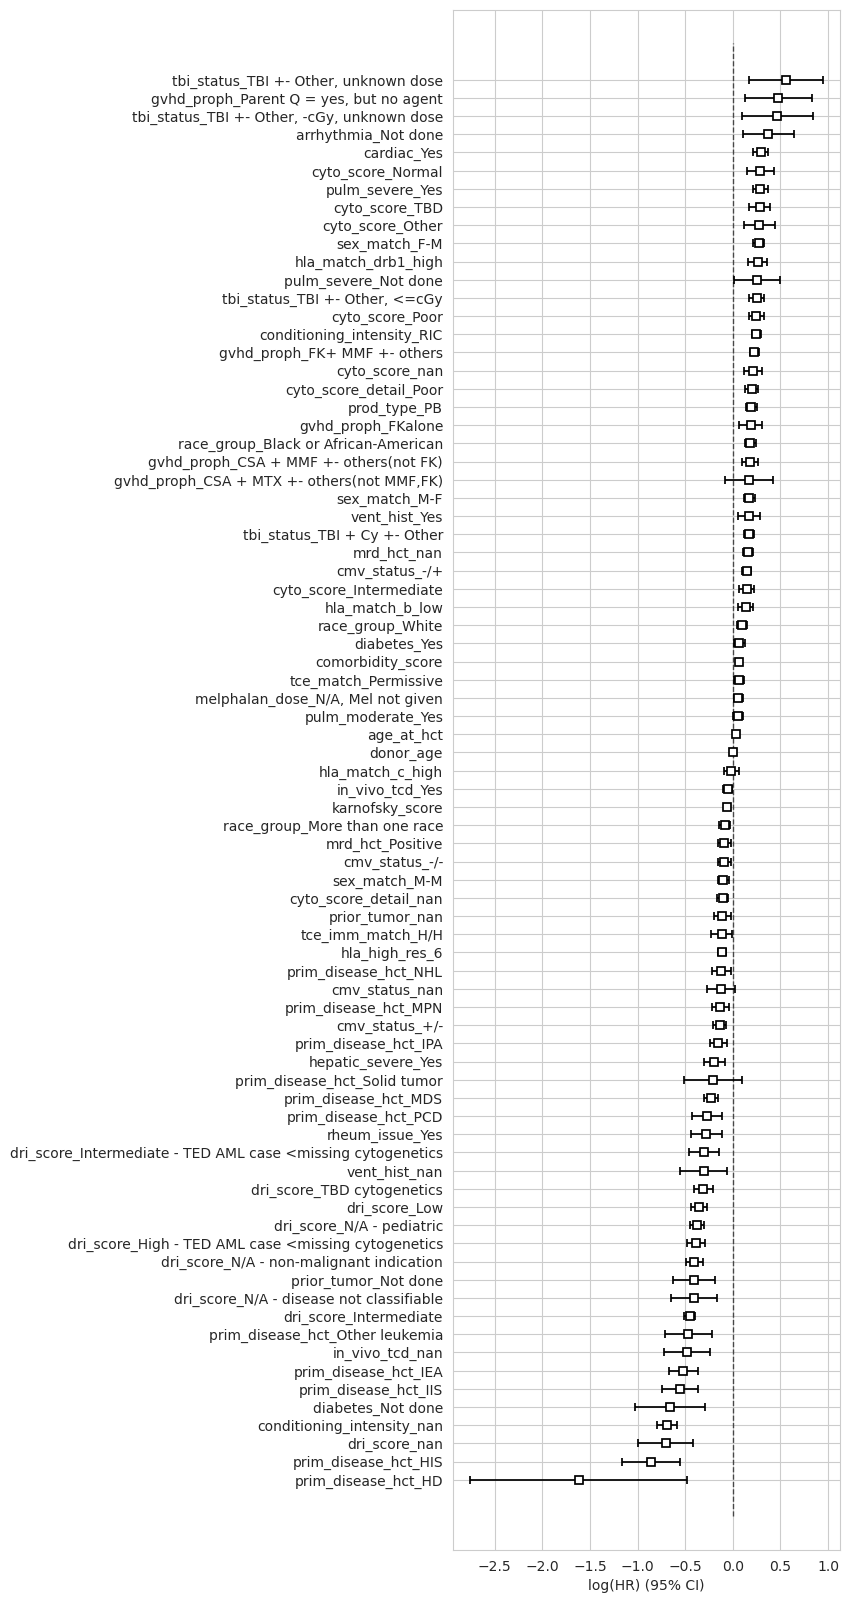

In [26]:
# Plot coeffients for Cox model with 
# a smaller set of features. 
# Notice there are still many features
# with coefficients very close to 0,
# and a few whose confidence intervals 
# even include 0. 
# It is likely that we could reduce the feature
# set much more without harming performance.
plt.figure(figsize=(5, 20))
cph2.plot()
plt.show()